In [2]:
import numpy as np
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K


from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense


from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics


from tensorflow.keras import losses


from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

In [3]:
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()
###載入資料

In [4]:
###先進行資料處理
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

In [5]:
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

In [6]:
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

In [7]:
### 建立VAE模型，增加2個encoding和decoding並調整維度，將最後一層的activation均改成relu

In [28]:
x = Input(shape=(784,))

enc_1 = Dense(128, activation='sigmoid')
enc_2 = Dense(128, activation='sigmoid')
enc_3 = Dense(128, activation='sigmoid')
enc_4 = Dense(128, activation='relu')

enc_mean = Dense(2)###之後才能畫二維圖
enc_log_var = Dense(2)

enc_x =enc_4(enc_3(enc_2(enc_1(x))))

dec_4 = Dense(100, activation='relu')
dec_3 = Dense(100, activation='sigmoid')
dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

x_hat = dec_1(dec_2(dec_3(dec_4(z))))

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [29]:
###自定義抽樣函數
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [30]:
###以Lambda將其轉換成Keras layer。
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])


In [31]:
###定義VAE的decoder
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(dec_3(dec_4(z_input))))

In [32]:
###組合看看ㄅ
x_hat = dec_1(dec_2(dec_3(dec_4(z))))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 128)          100480      input_10[0][0]                   
__________________________________________________________________________________________________
dense_47 (Dense)                (None, 128)          16512       dense_46[0][0]                   
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 128)          16512       dense_47[0][0]                   
____________________________________________________________________________________________

### 定義VAE的loss函數

In [33]:
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

### 訓練

In [37]:
VAE.compile(optimizer=Adam())

In [39]:
VAE.fit(X_train, 
        batch_size=512, 
        epochs=20)


Epoch 1/20
60000/60000 [==============================] - 1s 23us/sample - loss: 52.7912
Epoch 2/20
60000/60000 [==============================] - 1s 24us/sample - loss: 52.7821
Epoch 3/20
60000/60000 [==============================] - 1s 24us/sample - loss: 52.7733
Epoch 4/20
60000/60000 [==============================] - 1s 24us/sample - loss: 52.7688
Epoch 5/20
60000/60000 [==============================] - 1s 23us/sample - loss: 52.7449
Epoch 6/20
60000/60000 [==============================] - 1s 22us/sample - loss: 52.4803
Epoch 7/20
60000/60000 [==============================] - 1s 24us/sample - loss: 50.9920
Epoch 8/20
60000/60000 [==============================] - 1s 22us/sample - loss: 49.7854
Epoch 9/20
60000/60000 [==============================] - 1s 23us/sample - loss: 49.1474
Epoch 10/20
60000/60000 [==============================] - 1s 23us/sample - loss: 48.5256
Epoch 11/20
60000/60000 [==============================] - 1s 23us/sample - loss: 48.0770
Epoch 12/20
60000/6

### VAE視覺化

In [40]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_46 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_47 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_48 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_49 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_50 (Dense)             (None, 2)                 258       
Total params: 150,274
Trainable params: 150,274
Non-trainable params: 0
_____________________________________________________

In [42]:
VAE_Decoder = Model(z_input,dec_1(dec_2(dec_3(dec_4(z_input)))))

VAE_Decoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_52 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_53 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_54 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_55 (Dense)             (None, 784)               79184     
Total params: 99,684
Trainable params: 99,684
Non-trainable params: 0
_________________________________________________________________


In [47]:
###先做encoder的視覺化
indices = np.random.randint(X_train.shape[0], size=4000) 
VAE_latents = VAE_Encoder.predict(X_train[indices])

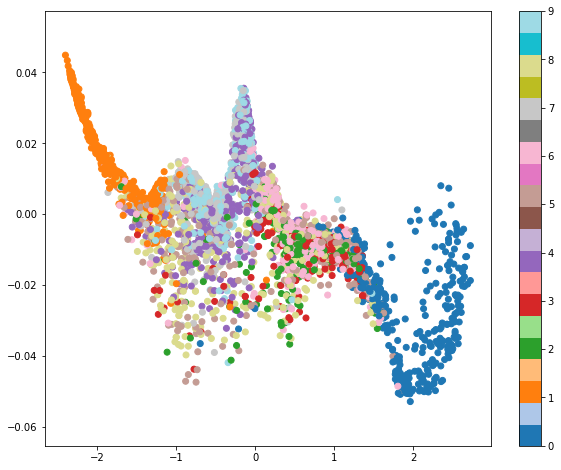

In [48]:
VAE_latents = VAE_Encoder.predict(X_train[indices])
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [51]:
###decoder的視覺化
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [53]:
n=15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

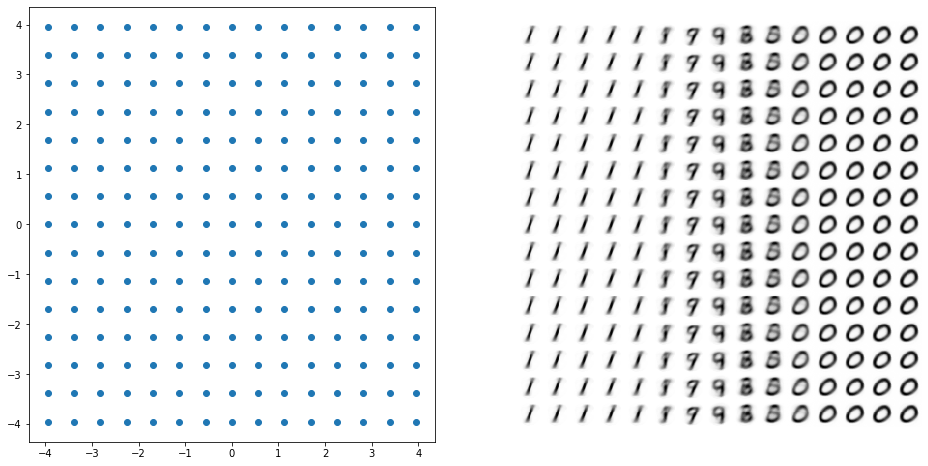

In [54]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()


In [55]:
###動態比較
idx_1, idx_2 = np.random.randint(X_train.shape[0], size=2)

In [56]:
def inBetween(t):
    data_0 = X_train[idx_1].reshape(28, 28)
    data_1 = X_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(X_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(X_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

In [57]:
interact(inBetween, t=FloatSlider(value=0, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>